In [1]:
import numpy as np
import pandas as pd
from os import listdir
from PIL import Image

from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['axes.grid'] = False
# plt.style.use('seaborn-v0_8-colorblind')

from fastai.tabular.all import *
from fastai.metrics import F1Score, Recall, Precision
from fastai.losses import CrossEntropyLossFlat

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
base_directory = '/home/shoaib/ZTFDataChallenge/'
run_path = base_directory + 'Fastai_Tabular_with_Features/Catagory_Balanced_largeClasses_F1_weightedCrossEntropy_nonRangeFiltered/'

In [3]:
### Loading the features by name
features_by_name = pd.read_parquet(base_directory + 'original_features_by_name.parquet')
# features_by_name = features_by_name.dropna(axis=0)
# features_by_name = features_by_name.query("type in @qso_types")
### Sampling to save memory
# features_by_name = features_by_name.sample(frac=0.1)

### Loading the features by OID
# features_by_oid = pd.read_parquet(base_directory + 'original_features_by_oid.parquet')
# features_by_oid = features_by_oid.dropna(axis=0)
# features_by_oid = features_by_oid.query("type in @qso_types")
### Sampling to save memory
# features_by_oid = features_by_oid.sample(frac=0.1)

In [4]:
feature_names = ['T2020_sigma2', 'mhps_ratio', 'mhps_low', 'mhps_high', 'Amplitude', 'AndersonDarling', 'Autocor_length',
                 'Beyond1Std', 'Con', 'Eta_e', 'Gskew', 'MaxSlope', 'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend',
                 'PercentAmplitude', 'Q31', 'PeriodLS_v2', 'Period_fit_v2', 'Psi_CS_v2', 'Psi_eta_v2', 'Rcs', 'Skew', 'SmallKurtosis',
                 'Std', 'StetsonK', 'Pvar', 'ExcessVar', 'GP_DRW_sigma', 'GP_DRW_tau', 'SF_ML_amplitude', 'SF_ML_gamma', 'IAR_phi',
                 'LinearTrend', 'Harmonics_mag_1', 'Harmonics_mag_2', 'Harmonics_mag_3', 'Harmonics_mag_4', 'Harmonics_mag_5',
                 'Harmonics_mag_6', 'Harmonics_mag_7', 'Harmonics_phase_2', 'Harmonics_phase_3', 'Harmonics_phase_4', 'Harmonics_phase_5',
                 'Harmonics_phase_6', 'Harmonics_phase_7', 'Harmonics_mse', 'mhps_non_zero', 'mhps_PN_flag']

band_feature_names = ['r_' + feature_name for feature_name in feature_names] + ['g_' + feature_name for feature_name in feature_names]
band_label_names = {i: feature_name for i, feature_name in enumerate(band_feature_names)}

In [5]:
data = features_by_name
print(f'There are {len(data)} rows in data right now.\n')
data['type'].value_counts()

There are 32187 rows in data right now.



type
Q     19613
A      3598
QX     2429
AX     1489
QR     1283
      ...  
NX        2
KX        1
K         1
KR        1
NR        1
Name: count, Length: 29, dtype: int64

In [6]:
# feature_ranges = {
#     'T2020_sigma2': (0, 0.2),
#     'mhps_ratio': (0, 1000),
#     'mhps_low': (0, 2),
#     'mhps_high': (0, 0.2),
#     'SmallKurtosis': (0, 20),
#     'ExcessVar': (0, 0.0004),
#     'GP_DRW_sigma': (0, 0.3),
#     'GP_DRW_tau': (0, 4000),
#     'SF_ML_amplitude': (0, 2),
#     'LinearTrend': (-0.003, 0.003),
#     'Harmonics_mag_1': (0, 400),
#     'Harmonics_mag_2': (0, 400),
#     'Harmonics_mag_3': (0, 400),
#     'Harmonics_mag_4': (0, 400),
#     'Harmonics_mag_5': (0, 400),
#     'Harmonics_mag_6': (0, 400),
#     'Harmonics_mag_7': (0, 400),
#     'Harmonics_mse': (0, 0.1)
# }

# for feature in feature_names:
#     if feature in feature_ranges:
#         range_min, range_max = feature_ranges[feature]
#         data = data[(data['r_' + feature] >= range_min) & (data['g_' + feature] <= range_max)]

# print(f'There are {len(data)} rows in data right now.\n')
# data['type'].value_counts()

In [7]:
top_types = data['type'].value_counts().nlargest(6).index
print(top_types, '\n\n')

data = data[data['type'].isin(top_types)]

Index(['Q', 'A', 'QX', 'AX', 'QR', 'QSO RLoud flat radio sp.'], dtype='object', name='type') 




In [8]:
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0).reset_index(drop=True)

print(f'There are {len(data)} rows in data right now.\n')
data['type'].value_counts()

There are 29100 rows in data right now.



type
Q                           19574
A                            3289
QX                           2428
AX                           1388
QR                           1278
QSO RLoud flat radio sp.     1143
Name: count, dtype: int64

### Training

In [9]:
min_count = data['type'].value_counts().min()
target_count = int(0.85 * min_count)

# Sample `target_count` examples from each class
train_df = (data.groupby('type', group_keys=False).apply(lambda x: x.sample(n=target_count, random_state=42)))
test_df = data.drop(train_df.index)

# train_df, test_df = train_test_split(data, test_size=0.15, random_state=42)

/tmp/ipykernel_22162/2216163211.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = (data.groupby('type', group_keys=False).apply(lambda x: x.sample(n=target_count, random_state=42)))


In [10]:
dls = TabularDataLoaders.from_df(train_df,
                                 y_names="type",
                                 cat_names=['r_mhps_PN_flag', 'g_mhps_PN_flag'],
                                 cont_names=['z'] + [X for X in band_feature_names if X not in ['r_mhps_PN_flag', 'g_mhps_PN_flag']],
                                 procs=[Categorify, FillMissing, Normalize],
                                 splits=RandomSplitter(valid_pct=0.15, seed=42)(range_of(train_df)),
                                )

dls.show_batch()

,r_mhps_PN_flag,g_mhps_PN_flag,z,r_T2020_sigma2,r_mhps_ratio,r_mhps_low,r_mhps_high,r_Amplitude,r_AndersonDarling,r_Autocor_length,r_Beyond1Std,r_Con,r_Eta_e,r_Gskew,r_MaxSlope,r_Mean,r_Meanvariance,r_MedianAbsDev,r_MedianBRP,r_PairSlopeTrend,r_PercentAmplitude,r_Q31,r_PeriodLS_v2,r_Period_fit_v2,r_Psi_CS_v2,r_Psi_eta_v2,r_Rcs,r_Skew,r_SmallKurtosis,r_Std,r_StetsonK,r_Pvar,r_ExcessVar,r_GP_DRW_sigma,r_GP_DRW_tau,r_SF_ML_amplitude,r_SF_ML_gamma,r_IAR_phi,r_LinearTrend,r_Harmonics_mag_1,r_Harmonics_mag_2,r_Harmonics_mag_3,r_Harmonics_mag_4,r_Harmonics_mag_5,r_Harmonics_mag_6,r_Harmonics_mag_7,r_Harmonics_phase_2,r_Harmonics_phase_3,r_Harmonics_phase_4,r_Harmonics_phase_5,r_Harmonics_phase_6,r_Harmonics_phase_7,r_Harmonics_mse,r_mhps_non_zero,g_T2020_sigma2,g_mhps_ratio,g_mhps_low,g_mhps_high,g_Amplitude,g_AndersonDarling,g_Autocor_length,g_Beyond1Std,g_Con,g_Eta_e,g_Gskew,g_MaxSlope,g_Mean,g_Meanvariance,g_MedianAbsDev,g_MedianBRP,g_PairSlopeTrend,g_PercentAmplitude,g_Q31,g_PeriodLS_v2,g_Period_fit_v2,g_Psi_CS_v2,g_Psi_eta_v2,g_Rcs,g_Skew,g_SmallKurtosis,g_Std,g_StetsonK,g_Pvar,g_ExcessVar,g_GP_DRW_sigma,g_GP_DRW_tau,g_SF_ML_amplitude,g_SF_ML_gamma,g_IAR_phi,g_LinearTrend,g_Harmonics_mag_1,g_Harmonics_mag_2,g_Harmonics_mag_3,g_Harmonics_mag_4,g_Harmonics_mag_5,g_Harmonics_mag_6,g_Harmonics_mag_7,g_Harmonics_phase_2,g_Harmonics_phase_3,g_Harmonics_phase_4,g_Harmonics_phase_5,g_Harmonics_phase_6,g_Harmonics_phase_7,g_Harmonics_mse,g_mhps_non_zero,type
0,0.0,0.0,1.130,0.029555,23.447669,0.018620,0.000790,0.309419,1.000000,74.999999,0.336585,1.131217e-11,0.160332,0.004366,238.412902,19.247066,0.009644,0.165981,0.260976,0.100000,0.025299,0.321721,0.997806,0.112806,0.245046,0.511350,0.425561,0.104292,-1.041151,0.185613,0.898456,1.000000,0.000080,0.049565,1267.618781,0.139295,0.665615,0.999166,0.000478,0.167749,-0.057729,-0.063404,0.008634,0.028781,0.022251,0.005977,3.694697,0.357043,1.984769,4.306976,0.640872,5.801638,0.007487,406.000001,0.039333,-1335.605469,0.040016,0.004875,0.404314,0.999996,68.000001,0.351010,6.446099e-11,0.298800,-0.066150,475.001221,19.718019,0.011494,0.176208,0.318182,-0.033333,0.035352,0.348912,0.997806,0.090222,0.219255,0.607344,0.401198,-0.124889,-0.523344,0.226648,0.826631,1.000000,1.008297e-04,4.882275e-02,175.057174,0.058003,-0.081955,0.998706,0.000573,-7.672134,-4.691930,-3.516863,-0.537924,0.370161,0.084055,0.023429,4.012288,2.817201,1.187456,4.305326,3.101869,1.661474,1.710626e-02,391.000002,QX
1,1.0,0.0,0.190,0.007886,42.379098,0.055426,0.002039,0.200933,0.999892,38.317757,0.282243,1.313562e-02,0.394561,0.146493,144.703434,18.689344,0.005739,0.063078,0.543925,-0.282866,0.023376,0.134751,1.000777,0.072312,0.202620,0.975606,0.334038,0.778990,0.727966,0.107263,0.785781,1.000000,0.000022,0.012546,195.308460,0.092545,0.228037,0.994469,0.000181,6.634283,5.149052,3.480905,1.995653,0.871836,0.295622,0.076964,4.631772,5.839599,0.572704,5.063836,0.825300,1.718099,0.005306,485.000004,0.016674,-1335.605469,0.095097,0.005440,0.262573,0.981663,17.950920,0.312883,9.262799e-03,0.420170,0.105342,270.687896,18.957216,0.007424,0.099630,0.361963,-0.223620,0.024365,0.196114,0.477429,0.104592,0.267321,0.922616,0.363166,0.390331,-0.326678,0.140740,0.829193,1.000000,4.610993e-05,2.045240e-02,107.113311,0.197577,0.288028,0.931380,0.000164,-7.672134,-4.691930,-3.516863,-0.537924,0.370161,0.084055,0.023429,4.584918,1.469747,2.156093,4.651746,1.670521,3.522955,1.053095e-02,287.000000,QX
2,0.0,0.0,0.470,0.011619,13.425148,0.053708,0.004045,0.225347,0.993698,8.000000,0.340541,1.131217e-11,0.771402,0.023159,48.973644,18.682306,0.006131,0.069326,0.410811,-0.033333,0.015647,0.160048,0.994729,0.040440,0.225549,1.036390,0.241007,0.064371,-0.238564,0.114535,0.786519,1.000000,0.000033,0.011980,83.558432,0.177608,0.243236,0.990164,-0.000086,0.167749,-0.057729,-0.063404,0.008634,0.028781,0.022251,0.010557,4.763582,6.080299,6.017871,4.754336,3.053766,0.565743,0.006302,179.000005,0.015318,-1335.605469,0.114168,0.006516,0.257759,0.956169,6.00

In [11]:
vocab = dls.vocab
class_counts = train_df['type'].value_counts()
class_counts = class_counts.reindex(vocab)
total = class_counts.sum()
weights = [total / c for c in class_counts]
weights = torch.tensor(weights, dtype=torch.float)

In [12]:
loss_func = CrossEntropyLossFlat(weight=weights)

In [13]:
learn = tabular_learner(dls, loss_func=loss_func,
                        metrics=[accuracy, Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')],
                    )

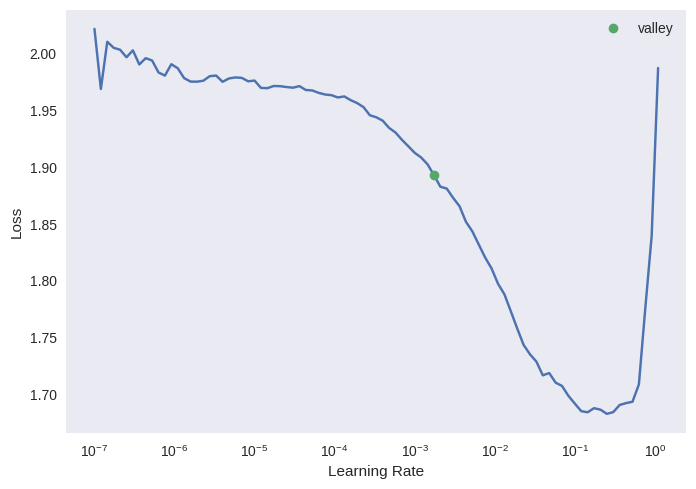

In [14]:
learning_rate = learn.lr_find(show_plot=True)

In [15]:
learn.fine_tune(20, base_lr=learning_rate.valley, freeze_epochs=1,
                cbs=[SaveModelCallback(monitor='f1_score', comp=np.greater, fname=run_path + 'best_model', with_opt=True),
                                        EarlyStoppingCallback(monitor='f1_score', comp=np.greater, min_delta=0.005, patience=3),
                                        CSVLogger(fname=run_path + 'history.csv')
                                    ]
                                )

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time


Better model found at epoch 0 with f1_score value: 0.40710829245421815.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.243551,18.819647,0.438627,0.433604,0.443357,0.428855,00:00
1,1.215990,3.306634,0.450644,0.442364,0.455134,0.440295,00:00
2,1.153466,60.893803,0.459227,0.452060,0.461881,0.452680,00:00
3,1.111048,1.703075,0.458369,0.453021,0.462770,0.452316,00:00
4,1.057660,16.768042,0.450644,0.448966,0.456697,0.439680,00:01
5,1.022626,8.035300,0.482403,0.482894,0.485383,0.480138,00:01
6,0.980031,5.322198,0.476395,0.482744,0.478747,0.479257,00:00
7,0.931748,7.459208,0.446352,0.455295,0.449630,0.446658,00:00
8,0.881895,20.589310,0.466094,0.463390,0.468464,0.462514,00:00


Better model found at epoch 0 with f1_score value: 0.42885539247282495.
Better model found at epoch 1 with f1_score value: 0.4402949906177345.
Better model found at epoch 2 with f1_score value: 0.45268035363805925.
Better model found at epoch 5 with f1_score value: 0.4801383551652847.
No improvement since epoch 5: early stopping


### Validation results

In [16]:
preds, targets = learn.get_preds()
class_names = dls.vocab
predicted_classes = torch.argmax(preds, dim=1)
print(classification_report(targets, predicted_classes, target_names=class_names))

                          precision    recall  f1-score   support

                       A       0.55      0.70      0.62       178
                      AX       0.63      0.55      0.59       194
                       Q       0.34      0.40      0.37       189
                      QR       0.41      0.30      0.35       208
QSO RLoud flat radio sp.       0.62      0.62      0.62       206
                      QX       0.34      0.34      0.34       190

                accuracy                           0.48      1165
               macro avg       0.48      0.49      0.48      1165
            weighted avg       0.48      0.48      0.48      1165



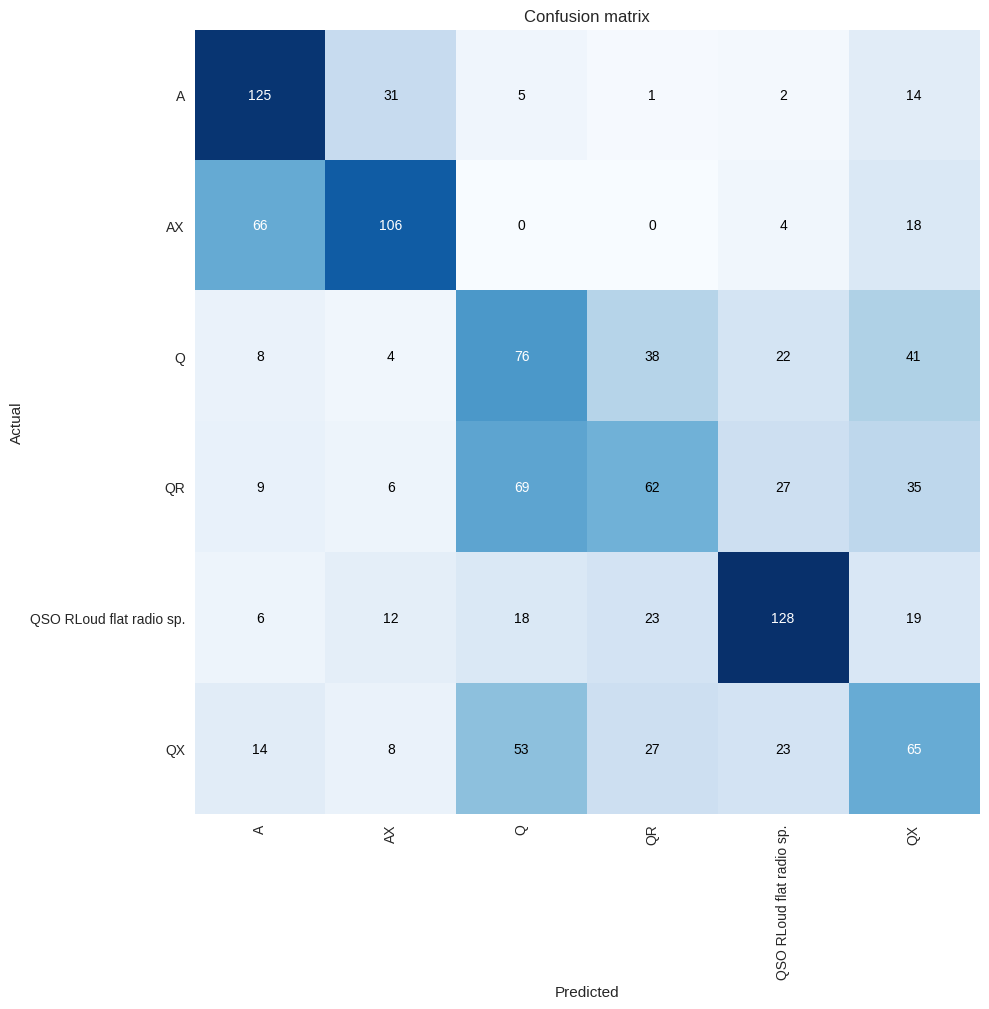

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10))

In [18]:
interp.plot_top_losses(k=6, figsize=(6, 6))  # Show 5 samples with largest loss

/home/shoaib/miniforge3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/shoaib/miniforge3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [19]:
interp.plot_top_losses(k=6, figsize=(6, 6), largest=False)  # Show 5 samples with lowest loss

### Test results

In [20]:
test_dls = learn.dls.test_dl(test_df, with_labels=True)
preds, targets = learn.get_preds(dl=test_dls)
class_names = test_dls.vocab

predicted_classes = torch.argmax(preds, dim=1)
print(classification_report(targets, predicted_classes, target_names=class_names))

                          precision    recall  f1-score   support

                       A       0.58      0.69      0.63      2318
                      AX       0.21      0.58      0.31       417
                       Q       0.94      0.42      0.58     18603
                      QR       0.02      0.29      0.04       307
QSO RLoud flat radio sp.       0.05      0.61      0.10       172
                      QX       0.13      0.39      0.19      1457

                accuracy                           0.45     23274
               macro avg       0.32      0.50      0.31     23274
            weighted avg       0.82      0.45      0.55     23274



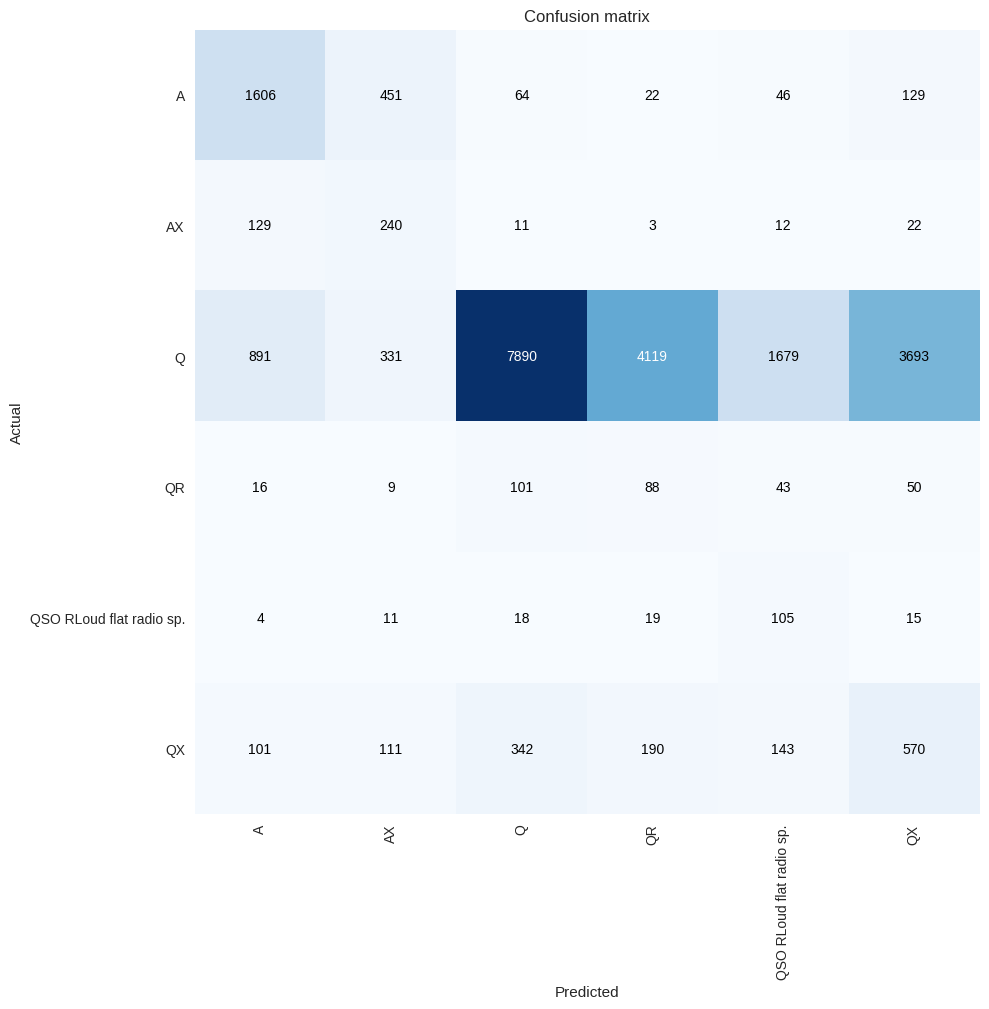

In [21]:
test_interp = ClassificationInterpretation.from_learner(learn, dl=test_dls)
test_interp.plot_confusion_matrix(figsize=(10, 10))

In [22]:
test_interp.plot_top_losses(k=6, figsize=(6, 6))  # Show 5 samples with largest loss

/home/shoaib/miniforge3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/shoaib/miniforge3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [23]:
test_interp.plot_top_losses(k=6, figsize=(6, 6), largest=False)  # Show 5 samples with lowest loss